# Notebook for checking diagnostics from AQUA project model runs

In [4]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import warnings
import xgcm

#=================================================
# Modify paths to point to output files
#=================================================
# Case name
case = 'Straight Coast'

# path to ocean_annual file
path_year = '/data/sragen/aquaplanet/MASTERS/straight_coast/run/DATA/500yr/23000101.ocean_annual.nc'
dy = xr.open_dataset(path_year, decode_times=True)

# path to ocean_month file
path_month = '/data/sragen/aquaplanet/MASTERS/straight_coast/run/DATA/500yr/23000101.ocean_month.nc'
dm = xr.open_dataset(path_month, decode_times=True)

# path to save figures
fig_path = '/data/sragen/aquaplanet/MASTERS/straight_coast/run/DATA/500yr/FIGURES/'


#=================================================
# Ignore runtime warnings: mean of empty slice
#=================================================
warnings.filterwarnings("ignore", message="Mean of empty slice")

#=================================================
# Modify latitudes to point to western and eastern
# boundaries of small basin and northern extent of SO.
# Comment out for AQUA and RIDGE cases. 
#=================================================
# x_west = np.where(dy['xh']==211)[0][0]
# x_east = np.where(dy['xh']==351)[0][0]
# y = np.where(dy['yq']==-35)[0][0]
# y_south = np.where(dy['yq']==-71)[0][0]
# y_north = np.where(dy['yq']==71)[0][0]


#=================================================
# Make grid object for XGCM 
#=================================================
grid = xgcm.Grid(dm, coords={'x': {'center':'xq', 'left':'xh'}, 'y': {'center':'yq', 'left':'yh'}})


/home/sragen/.conda/envs/aqua/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


## Functions used in this notebook:

In [5]:
def inferred_heat_transport(energy_in):
    ae = 6.373E6 
    from scipy import integrate
    lat = energy_in.yh
    norm = np.cos(np.deg2rad(lat)) / np.cos(np.deg2rad(lat)).mean(dim='yh')
    imbalance = (energy_in * norm).mean(dim='yh')
    balanced = energy_in - imbalance
    lat_rad = np.deg2rad(lat)
    coslat = np.cos(lat_rad)
    field = coslat*np.nansum(balanced, axis=1)
    field[np.isnan(field)] = 0
    latax = field.get_axis_num('yh')
    integral = integrate.cumtrapz(field, x=lat_rad, initial=0., axis=latax)
    result = (1E-15 * 2/180 * np.math.pi * ae**2 * integral)
    result_xarray = field.copy()
    result_xarray.values = result
    return result_xarray

def latlon_gridm(dataset):
    XH, YH = np.meshgrid(dataset['xh'], dataset['yh'])
    XH = XH * 111111 * np.cos(np.deg2rad(YH))
    YH = YH * 111111
    field = dataset['tos'].isel(time=0)
    XH_xarray = field.copy() 
    XH_xarray.values = XH
    XH_xarray.attrs['long_name'] = 'h point longitude in meters gridded'
    XH_xarray.attrs['units'] = 'm'
    XH_xarray.rename({'yh':'yq'})
    YH_xarray = field.copy() 
    YH_xarray.values = YH
    YH_xarray.attrs['long_name'] = 'h point latitude in meters gridded'
    YH_xarray.attrs['units'] = 'm'
    YH_xarray.rename({'xh':'xq'})
    dataset['XH'] = XH_xarray
    dataset['YH'] = YH_xarray
    return dataset['XH'], dataset['YH']


Integrate surface heat flux to check OHT

In [6]:
netSHF = dm['SW'][-31:,:,:].mean(dim='time')+dm['LwLatSens'][-31:,:,:].mean(dim='time')
netSHF.shape

(81, 180)

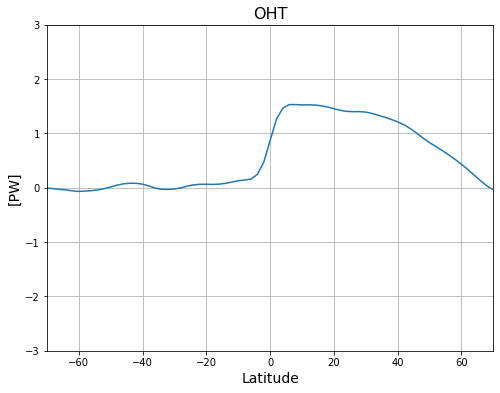

In [7]:
netSHF = dm['SW'][-31:,:,:].mean(dim='time')+dm['LwLatSens'][-31:,:,:].mean(dim='time')

OHT = inferred_heat_transport(netSHF)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(dm['yh'], OHT)
plt.xlim(-70,70), plt.ylim(-3, 3)
plt.title('OHT', fontsize=16), plt.xlabel('Latitude', fontsize=14), plt.ylabel('[PW]', fontsize=14)
plt.grid()
plt.savefig(fig_path+'OHT_inferred.png')
plt.show()

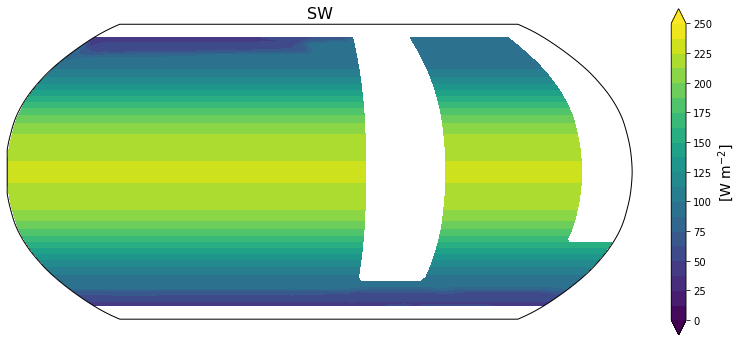

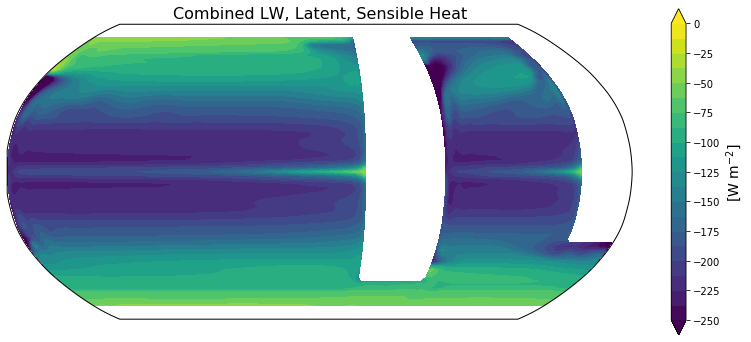

In [8]:
b = np.linspace(0, 250, 21, endpoint=True)
t = np.linspace(0, 250, 11, endpoint=True)
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=180.0))
plt.contourf(dy['xh'], dy['yh'], dm['SW'].mean(dim='time'), b, cmap='viridis', extend='both',  transform=ccrs.PlateCarree())
cbar = plt.colorbar(ticks=t, boundaries=t, spacing='uniform', extend='both')
cbar.ax.set_ylabel('[W m$^{-2}$]', fontsize=14)
plt.ylabel('Latitude', fontsize=14), plt.xlabel('Longitude', fontsize=14)
plt.title('SW', fontsize=16)
plt.savefig(fig_path+'SW.png')
plt.show()

b = np.linspace(-250, 0, 21, endpoint=True)
t = np.linspace(-250, 0, 11, endpoint=True)
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=180.0))
plt.contourf(dy['xh'], dy['yh'], dm['LwLatSens'].mean(dim='time'), b, cmap='viridis', extend='both',  transform=ccrs.PlateCarree())
cbar = plt.colorbar(ticks=t, boundaries=t, spacing='uniform', extend='both')
cbar.ax.set_ylabel('[W m$^{-2}$]', fontsize=14)
plt.ylabel('Latitude', fontsize=14), plt.xlabel('Longitude', fontsize=14)
plt.title('Combined LW, Latent, Sensible Heat', fontsize=16)
plt.savefig(fig_path+'LW_Lat_Sens.png')
plt.show()


Take a look at zonal velocities at the northern boundary

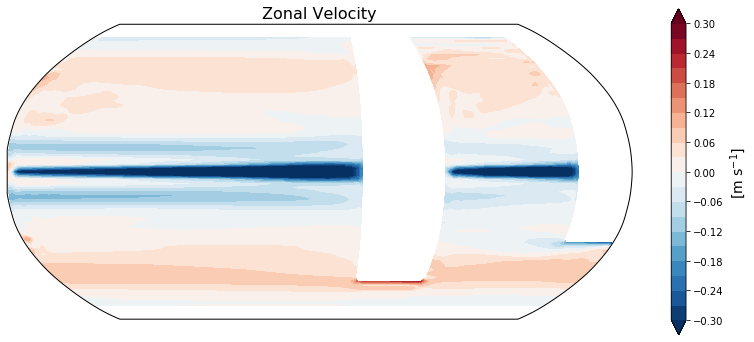

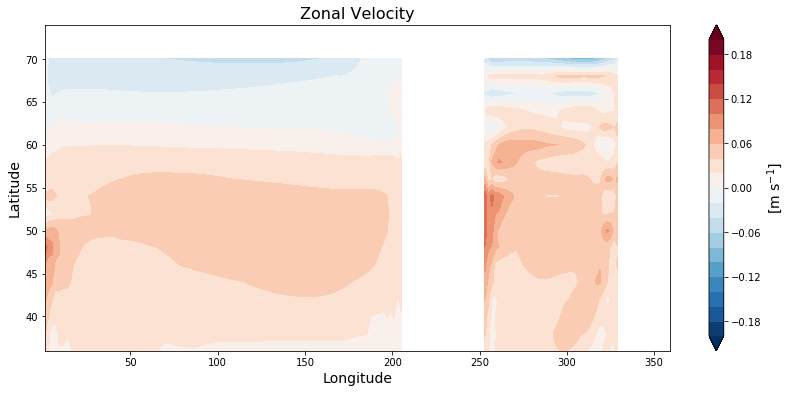

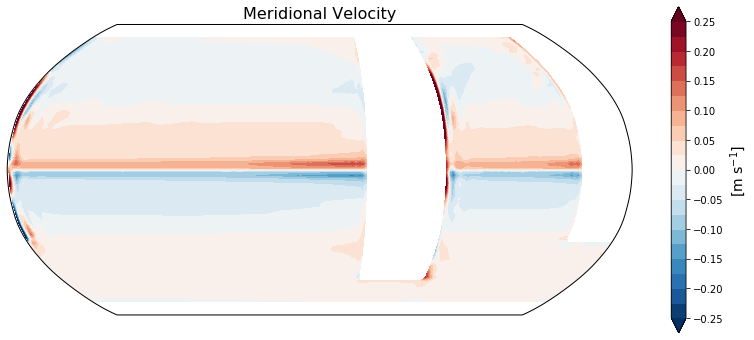

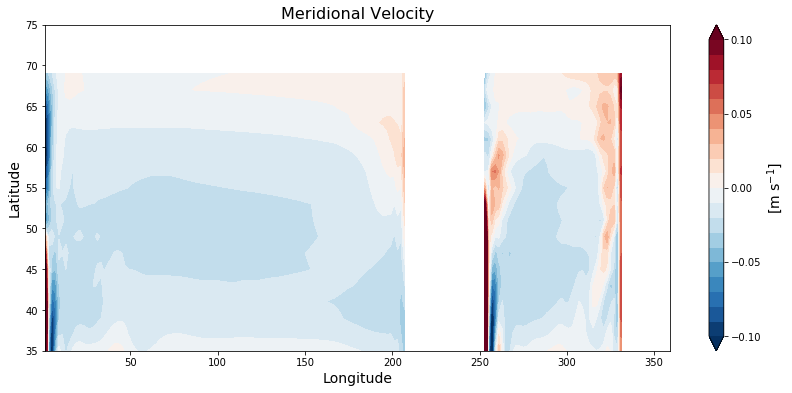

In [9]:
b = np.linspace(-0.3, 0.3, 21, endpoint=True)
t = np.linspace(-0.3, 0.3, 11, endpoint=True)
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=180.0))
plt.contourf(dm['xh'], dm['yh'], dm['uo'].isel(zl=0).mean(dim='time'), 
             b, cmap='RdBu_r', extend='both',  transform=ccrs.PlateCarree())
cbar = plt.colorbar(ticks=t, boundaries=t, spacing='uniform', extend='both')
cbar.ax.set_ylabel('[m s$^{-1}$]', fontsize=14)
plt.ylabel('Latitude', fontsize=14), plt.xlabel('Longitude', fontsize=14)
plt.title('Zonal Velocity', fontsize=16)
plt.savefig(fig_path+'Uo.png')
plt.show()

b = np.linspace(-0.2, 0.2, 21, endpoint=True)
fig = plt.figure(figsize=(14, 6))
plt.contourf(dm['xh'], dm['yh'].sel(yh=slice(35,75)), 
             dm['uo'].sel(yh=slice(35, 75)).isel(zl=0).mean(dim='time'), b, cmap='RdBu_r', extend='both')
cbar = plt.colorbar(ticks=t, boundaries=t, spacing='uniform', extend='both')
cbar.ax.set_ylabel('[m s$^{-1}$]', fontsize=14)
plt.ylabel('Latitude', fontsize=14), plt.xlabel('Longitude', fontsize=14)
plt.title('Zonal Velocity', fontsize=16)
plt.savefig(fig_path+'Uo_north.png')
plt.show()

b = np.linspace(-0.25, 0.25, 21, endpoint=True)
t = np.linspace(-0.25, 0.25, 11, endpoint=True)
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=180.0))
plt.contourf(dm['xh'], dm['yq'], dm['vo'].isel(zl=0).mean(dim='time'), 
             b, cmap='RdBu_r', extend='both',  transform=ccrs.PlateCarree())
cbar = plt.colorbar(ticks=t, boundaries=t, spacing='uniform', extend='both')
cbar.ax.set_ylabel('[m s$^{-1}$]', fontsize=14)
plt.ylabel('Latitude', fontsize=14), plt.xlabel('Longitude', fontsize=14)
plt.title('Meridional Velocity', fontsize=16)
plt.savefig(fig_path+'Vo.png')
plt.show()

b = np.linspace(-0.1, 0.1, 21, endpoint=True)
fig = plt.figure(figsize=(14, 6))
plt.contourf(dm['xh'], dm['yq'].sel(yq=slice(35, 75)),
             dm['vo'].sel(yq=slice(35, 75)).isel(zl=0).mean(dim='time'), b, cmap='RdBu_r', extend='both')
cbar = plt.colorbar(ticks=t, boundaries=t, spacing='uniform', extend='both')
cbar.ax.set_ylabel('[m s$^{-1}$]', fontsize=14)
plt.ylabel('Latitude', fontsize=14), plt.xlabel('Longitude', fontsize=14)
plt.title('Meridional Velocity', fontsize=16)
plt.savefig(fig_path+'Vo_north.png')
plt.show()

Take a look at velocities in the subtropical gyre: Make a latitudinal cross section of meridional velocity and a longitudinal cross section of zonal velocity.

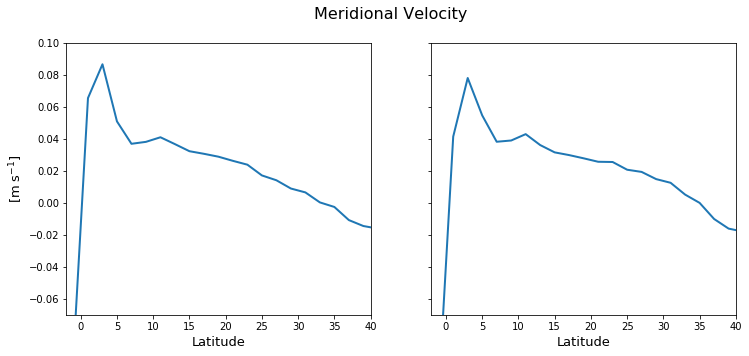

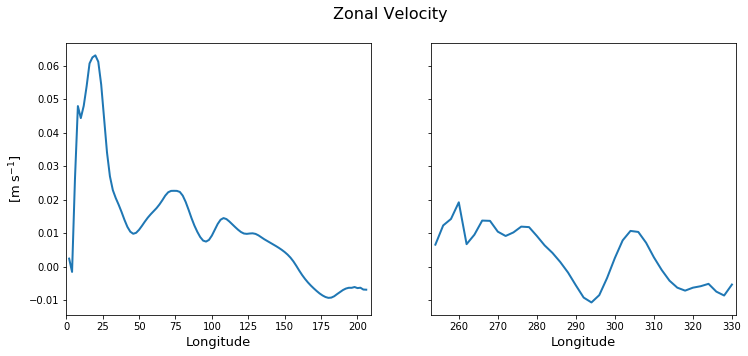

In [10]:
fig, axes = plt.subplots(ncols=2, nrows=1, sharey=True, figsize=(12,5))
axes[0].plot(dm['yq'], dm['vo'][-6:,:,:,:].isel(zl=0).sel(xh=51).mean(dim='time'), linewidth=2)
axes[0].set_xlim(-2,40); axes[0].set_ylim(-0.07, 0.1)
axes[0].set_ylabel('[m s$^{-1}$]', fontsize=13); axes[0].set_xlabel('Latitude', fontsize=13)
axes[1].plot(dm['yq'], dm['vo'][-6:,:,:,:].isel(zl=0).sel(xh=141).mean(dim='time'), linewidth=2)
axes[1].set_xlim(-2,40)
axes[1].set_xlabel('Latitude', fontsize=13)
fig.suptitle('Meridional Velocity', fontsize=16)
plt.show()

fig, axes = plt.subplots(ncols=2, nrows=1, sharey=True, figsize=(12,5))
axes[0].plot(dm['xq'], dm['uo'][-6:,:,:,:].isel(zl=0).sel(yh=26).mean(dim='time'), linewidth=2)
axes[0].set_xlim(0,209)
axes[0].set_ylabel('[m s$^{-1}$]', fontsize=13); axes[0].set_xlabel('Longitude', fontsize=13)
axes[1].plot(dm['xq'], dm['uo'][-6:,:,:,:].isel(zl=0).sel(yh=26).mean(dim='time'), linewidth=2)
axes[1].set_xlim(253,331)
axes[1].set_xlabel('Longitude', fontsize=13)
fig.suptitle('Zonal Velocity', fontsize=16)
plt.show()

Now, let's look at a longitudinal cross-section of meridional velocity (vo)

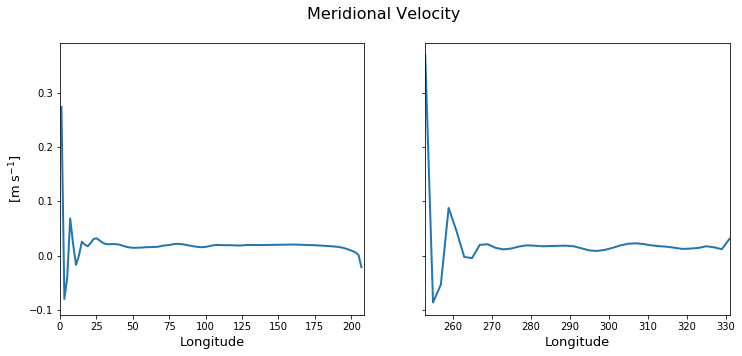

In [11]:
fig, axes = plt.subplots(ncols=2, nrows=1, sharey=True, figsize=(12,5))
axes[0].plot(dm['xh'], dm['vo'][-6:,:,:,:].isel(zl=0).sel(yq=27).mean(dim='time'), linewidth=2)
axes[0].set_xlim(0,209)
axes[0].set_ylabel('[m s$^{-1}$]', fontsize=13); axes[0].set_xlabel('Longitude', fontsize=13)
axes[1].plot(dm['xh'], dm['vo'][-6:,:,:,:].isel(zl=0).sel(yq=27).mean(dim='time'), linewidth=2)
axes[1].set_xlim(253,331)
axes[1].set_xlabel('Longitude', fontsize=13)
fig.suptitle('Meridional Velocity', fontsize=16)
plt.savefig(fig_path+'Vo_section.png')
plt.show()

Viscosities and boundary layer thicknesses:
What's viscocity and BL thickness at northern edge? What about western edge?
Figure out scaling (help from Chris Wolfe's document)

In [12]:
# Kh = 2 * omega * ae**2 * ((3**(1/2) * 2 * 2*(np.pi/180)) / (2 * np.pi))**(3)

omega = 7.29E-5
ae = 6.373E6  

Kh = 2 * omega * ae**2 * ((3**(1/2) * 2 * 2*(np.pi/180)) / (2 * np.pi))**(3)
print(Kh)

print()

42208.480190378476



Latitudinal plots of wind stress curl

In [13]:
dm['XH'], dm['YH'] = latlon_gridm(dm)

dy = grid.diff(dm['YH'], 'y')
dx = grid.diff(dm['XH'], 'x')

dy = dy.rename({'xh':'xq'})
dx = dx.rename({'yh':'yq'})

dtaux = grid.diff(dm['taux'], 'y')
dtaux_dy = dtaux / dy.isel(xq=0)

dtauy = grid.diff(dm['tauy'], 'x')
dtauy_dx = dtauy / dx.isel(yq=0)

wind_curl = dtauy_dx - dtaux_dy

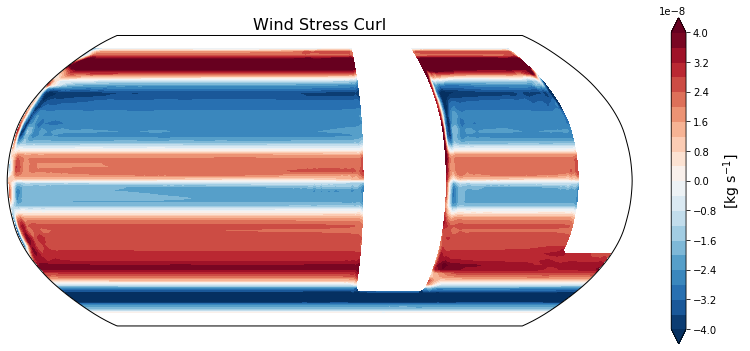

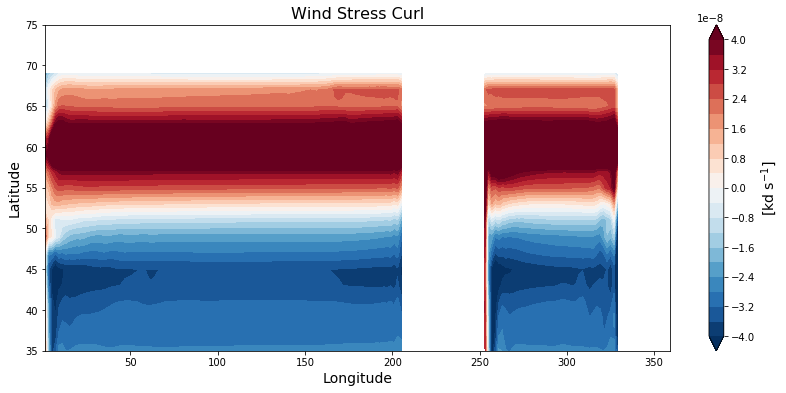

In [14]:
b = np.linspace(-4e-8, 4e-8, 21, endpoint=True)
t = np.linspace(-4e-8, 4e-8, 11, endpoint=True)
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=180.0))
plt.contourf(dy['xq'], dy['yq'], wind_curl.mean(dim='time'), 
             b, cmap='RdBu_r', extend='both', transform=ccrs.PlateCarree())
cbar = plt.colorbar(ticks=t, boundaries=t, spacing='uniform', extend='both')
cbar.ax.set_ylabel('[kg s$^{-1}$]', fontsize=14)
plt.ylabel('Latitude', fontsize=14), plt.xlabel('Longitude', fontsize=14)
plt.title('Wind Stress Curl', fontsize=16)
plt.savefig(fig_path+'wind_curl.png')
plt.show()

fig = plt.figure(figsize=(14, 6))
plt.contourf(dy['xq'], dy['yq'].sel(yq=slice(35, 75)), wind_curl.sel(yq=slice(35, 75)).mean(dim='time'), 
             b, cmap='RdBu_r', extend='both')
cbar = plt.colorbar(ticks=t, boundaries=t, spacing='uniform', extend='both')
cbar.ax.set_ylabel('[kd s$^{-1}$]', fontsize=14)
plt.ylabel('Latitude', fontsize=14), plt.xlabel('Longitude', fontsize=14)
plt.title('Wind Stress Curl', fontsize=16)
plt.savefig(fig_path+'wind_curl_north.png')
plt.show()

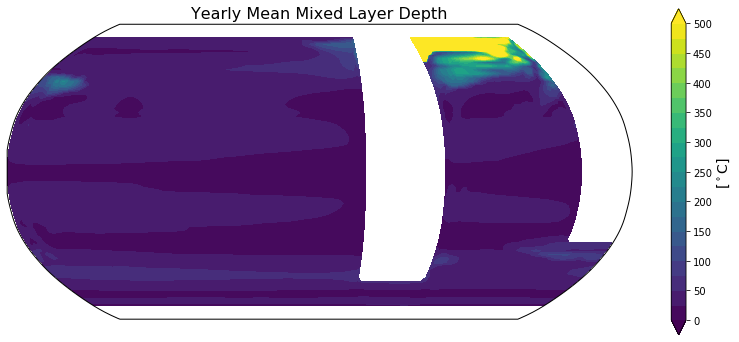

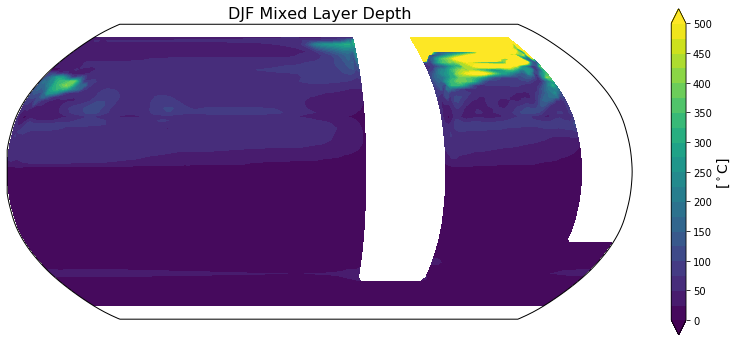

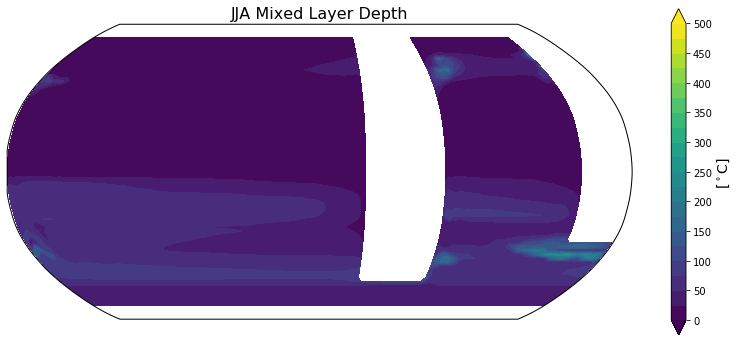

In [17]:
mlt = dm['mlotst'][:30,:,:]
# np.asarray(dm_s['mlotst'][:])

mlt_djf = np.nanmean(mlt.where(dm['time.season'] == 'DJF'), axis=0)
mlt_jja = np.nanmean(mlt.where(dm['time.season'] == 'JJA'), axis=0)

b = np.linspace(0, 500, 21, endpoint=True)
t = np.linspace(0, 500, 11, endpoint=True)
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=180.0))
plt.contourf(dm['xh'], dm['yh'], np.nanmean(mlt, axis=0), b, extend='both',  transform=ccrs.PlateCarree())
cbar = plt.colorbar(ticks=t, boundaries=t, spacing='uniform', extend='both')
cbar.ax.set_ylabel('[$^\circ$C]', fontsize=14)
plt.ylabel('Latitude', fontsize=14), plt.xlabel('Longitude', fontsize=14)
plt.title('Yearly Mean Mixed Layer Depth', fontsize=16)
plt.show()

fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=180.0))
plt.contourf(dm['xh'], dm['yh'], mlt_djf, b, extend='both',  transform=ccrs.PlateCarree())
cbar = plt.colorbar(ticks=t, boundaries=t, spacing='uniform', extend='both')
cbar.ax.set_ylabel('[$^\circ$C]', fontsize=14)
plt.ylabel('Latitude', fontsize=14), plt.xlabel('Longitude', fontsize=14)
plt.title('DJF Mixed Layer Depth', fontsize=16)
plt.show()

fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=180.0))
plt.contourf(dm['xh'], dm['yh'], mlt_jja, b, extend='both',  transform=ccrs.PlateCarree())
cbar = plt.colorbar(ticks=t, boundaries=t, spacing='uniform', extend='both')
cbar.ax.set_ylabel('[$^\circ$C]', fontsize=14)
plt.ylabel('Latitude', fontsize=14), plt.xlabel('Longitude', fontsize=14)
plt.title('JJA Mixed Layer Depth', fontsize=16)
plt.show()

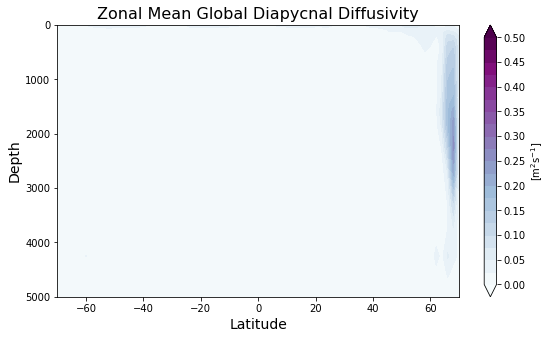

NameError: name 'x_west' is not defined

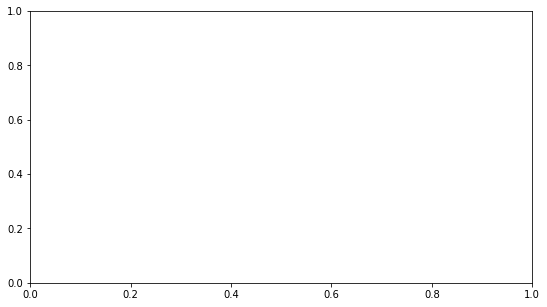

In [18]:
t = np.linspace(0, .5, 11, endpoint=True)
b = np.linspace(0, .5, 21, endpoint=True)
fig, ax = plt.subplots(figsize=(9,5))
cf = ax.contourf(dm['yh'], dm['zi'], dm.Kd_interface.mean(dim='time').mean(dim='xh'), 
                 b, extend='both', cmap='BuPu')
ax.invert_yaxis()
# ax.plot([-55,-55], [0,5000], 'gray'), ax.plot([-35,-35], [0,5000], 'gray')
ax.set_xlim(-70,70)
cbar = fig.colorbar(cf, ax=ax, ticks=t)
cbar.ax.set_ylabel('[m$^2$s$^{-1}$]')
plt.ylabel('Depth', fontsize=14), plt.xlabel('Latitude', fontsize=14)
ax.set_title('Zonal Mean Global Diapycnal Diffusivity', fontsize=16)
plt.show()

fig, ax = plt.subplots(figsize=(9,5))
cf = ax.contourf(dm['yh'], dm['zi'], dm.Kd_interface.isel(xh=slice(x_west,x_east)).mean(dim='time').mean(dim='xh'), 
                 b, extend='both', cmap='BuPu')
ax.invert_yaxis()
# ax.plot([-55,-55], [0,5000], 'gray'), ax.plot([-35,-35], [0,5000], 'gray')
ax.set_xlim(-70,70)
cbar = fig.colorbar(cf, ax=ax)
cbar.ax.set_ylabel('[m$^2$s$^{-1}$]')
plt.ylabel('Depth', fontsize=14), plt.xlabel('Latitude', fontsize=14)
ax.set_title('Zonal Mean Small Basin Diffusivity', fontsize=16)
plt.show()

fig, ax = plt.subplots(figsize=(9,5))
cf = ax.contourf(dm['yh'], dm['zi'], dm.Kd_interface.isel(xh=slice(0,x_west)).mean(dim='time').mean(dim='xh'), 
                 b, extend='both', cmap='BuPu')
ax.invert_yaxis()
# ax.plot([-55,-55], [0,5000], 'gray'), ax.plot([-35,-35], [0,5000], 'gray')
ax.set_xlim(-70,70)
cbar = fig.colorbar(cf, ax=ax, ticks=t)
cbar.ax.set_ylabel('[m$^2$s$^{-1}$]')
plt.ylabel('Depth', fontsize=14), plt.xlabel('Latitude', fontsize=14)
ax.set_title('Zonal Mean Large Basin Diffusivity', fontsize=16)
plt.show()

In [ ]:
b = np.linspace(.05, .5, 21, endpoint=True)
t = np.linspace(.05, .5, 11, endpoint=True)
fig, ax = plt.subplots(figsize=(9,5))
cf = ax.contourf(dm['yh'], dm['zi'], dm.Kd_ePBL.mean(dim='time').mean(dim='xh'), b,
                extend='both', cmap='BuPu')
ax.invert_yaxis()
ax.set_xlim(-70,70)
cbar = fig.colorbar(cf, ax=ax, ticks=t)
cbar.ax.set_ylabel('[m$^2$s$^{-1}$]')
plt.ylabel('Depth', fontsize=14), plt.xlabel('Latitude', fontsize=14)
ax.set_title('Zonal Mean Global ePBL Diapycnal Diffusivity', fontsize=16)
plt.show()

fig, ax = plt.subplots(figsize=(9,5))
cf = ax.contourf(dm['yh'], dm['zi'], dm.Kd_ePBL.isel(xh=slice(x_west,x_east)).mean(dim='time').mean(dim='xh'), b,
                extend='both', cmap='BuPu')
ax.invert_yaxis()
ax.set_xlim(-70,70)
cbar = fig.colorbar(cf, ax=ax, ticks=t)
cbar.ax.set_ylabel('[m$^2$s$^{-1}$]')
plt.ylabel('Depth', fontsize=14), plt.xlabel('Latitude', fontsize=14)
ax.set_title('Zonal Mean Small Basin ePBL Diapycnal Diffusivity', fontsize=16)
plt.show()

fig, ax = plt.subplots(figsize=(9,5))
cf = ax.contourf(dm['yh'], dm['zi'], dm.Kd_ePBL.isel(xh=slice(0,x_west)).mean(dim='time').mean(dim='xh'), b,
                extend='both', cmap='BuPu')
ax.invert_yaxis()
ax.set_xlim(-70,70)
cbar = fig.colorbar(cf, ax=ax, ticks=t)
cbar.ax.set_ylabel('[m$^2$s$^{-1}$]')
plt.ylabel('Depth', fontsize=14), plt.xlabel('Latitude', fontsize=14)
ax.set_title('Zonal Mean Large Basin ePBL Diapycnal Diffusivity', fontsize=16)
plt.show()

In [ ]:
# b = np.linspace(.05, .5, 21, endpoint=True)
# t = np.linspace(.05, .5, 11, endpoint=True)

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=180.0))
plt.contourf(dm['xh'], dm['yh'],  dm.Kd_ePBL.isel(zi=0).mean(dim='time'), extend='both', cmap='BuPu', transform=ccrs.PlateCarree())
cbar = plt.colorbar(spacing='uniform')
cbar.ax.set_ylabel('[m$^2$s$^{-1}$]')
plt.ylabel('Latitude', fontsize=14), plt.xlabel('Longitude', fontsize=14)
ax.set_title('Zonal Mean Global ePBL Diffusivity (Surface)', fontsize=16)
plt.show()

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=180.0))
plt.contourf(dm['xh'], dm['yh'],  dm.Kd_ePBL.isel(zi=-1).mean(dim='time'), extend='both', cmap='BuPu', transform=ccrs.PlateCarree())
cbar = plt.colorbar(spacing='uniform')
cbar.ax.set_ylabel('[m$^2$s$^{-1}$]')
plt.ylabel('Latitude', fontsize=14), plt.xlabel('Longitude', fontsize=14)
ax.set_title('Zonal Mean Global ePBL Diffusivity (Bottom)', fontsize=16)
plt.show()
